# NYC Schools Additional Exploration
---
Initially exploration was started following [Dataquest.io](https://www.dataquest.io) guidlines.

However I got a bit obsessed and squeezed out quite some capabilities from matplotlib. The results are really nice. You can scroll to the very bottom to ensure!

This research would address following questions:
 - Determing wheter there's a correlation between class size and SAT scores
 - Figuring out which neighborhoods have the best schools
     - In combination with a dataset containing property values for NY districts, we could find the least expensive neighborhoods that have good schools.
 - Investigating the differences between parent, teacher, and student responses to surveys.
 - Assigning scores to schools based on sat_score and other attributes.
 
Lets get started :)

## Initialize all the data and libraries

In [1]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in Surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11",
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN cols

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert cols data to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense dataset

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP columns to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine all datasets together

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Find correlations
*sat_score* correlation to all columns

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations.loc['AVERAGE CLASS SIZE'])

0.38101433081


## Class size to SAT correlation

In [10]:
for col in combined.columns.values:
    if 'CLASS' in col:
        print(col)

AVERAGE CLASS SIZE
SIZE OF SMALLEST CLASS
SIZE OF LARGEST CLASS


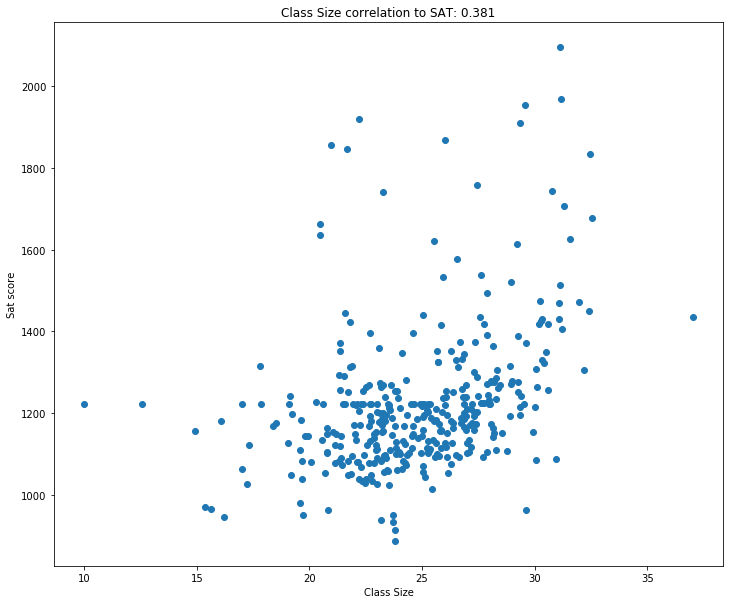

In [11]:
# Visualize relationship via scatterplot
fig, ax = plt.subplots(figsize=(12,10))

ax.scatter(combined['AVERAGE CLASS SIZE'],combined['sat_score'])
ax.set_title('Class Size correlation to SAT: {:.3f}'.format(correlations.loc['AVERAGE CLASS SIZE']))
ax.set_xlabel('Class Size')
ax.set_ylabel('Sat score')
  
plt.show()

### Findings
There is evident positive correlation for class size and sat score. Which is quite counterintuitive.

Also there is a small cluster of very low sat scores for class size approximately 24.

## Neighbours with best schools
Via mapping averaged sat scores per district with colormap applied.

In [171]:
combined.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.0,400.0,387.0,1182.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.0,393.0,392.0,1194.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
8,02M294,ESSEX STREET ACADEMY,53,394.0,384.0,378.0,1156.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.0,375.0,362.0,1111.0,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02


In [173]:
import numpy
from scipy import stats

def calc_trim_mean(series):
    trimmed_mean = stats.trim_mean(series, proportiontocut=0.1)
    return trimmed_mean

districts = combined.groupby('school_dist').agg(calc_trim_mean)
districts.reset_index(inplace=True)
districts.head(5)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1,...,12,12.0,10003.166667,659.500000,1.333333,0,0,0,40.719022,-73.982377
1,02,418.242910,434.223507,415.949403,1268.890821,101.140144,150.320192,109.922500,131.202419,2,...,12,12.0,10014.825000,518.650000,1.200000,0,0,0,40.740311,-73.992663
2,03,420.935821,431.297015,416.998806,1268.131642,117.220192,168.726923,152.105000,150.061290,3,...,12,12.0,10023.600000,551.200000,1.700000,0,0,0,40.780456,-73.978664
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4,...,12,12.0,10029.857143,580.857143,1.142857,0,0,0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5,...,12,12.0,10030.142857,609.857143,1.142857,0,0,0,40.817077,-73.949251


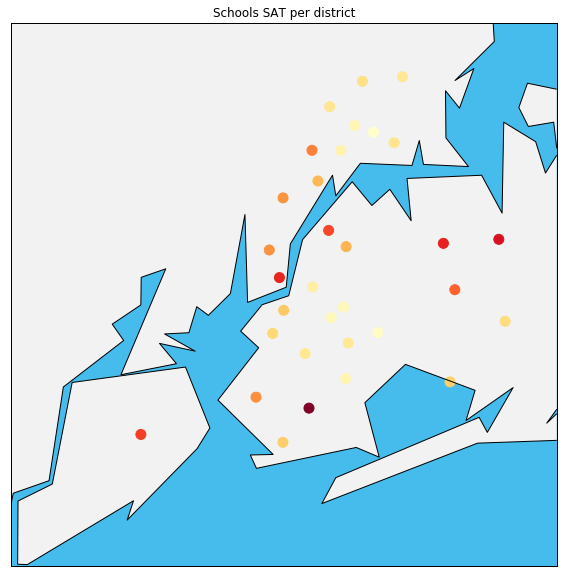

In [175]:
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes,latitudes,
          s=100,
          zorder=2, 
          latlon=True,
          c=districts['sat_score'], cmap='YlOrRd')

m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
m.drawcoastlines()
m.drawrivers(color='#0089E0') # Default colour is black but it can be customized
m.drawcountries()

ax.set_title('Schools SAT per district')

#ax.colorbar()
plt.show()

### Findings
_The darker the color - the better the score._

According to the mapped data, Brookly has by far the best performing schools.

Other districts with high-sat schools are: Staten Island, Queens and South Manhattan

About Boroughs - [Geographical districts of NYC](http://www.nycgo.com/boroughs-neighborhoods)

## Neighbours with best schools and property values
---
It would be great to find districts with not very expensive property and fairly decent schools. Lets visualize it!

How to accomplish this? I can imagine we need to highlight NYC districts, filling it using colormap according to the average property price. Then sprinkle those districts with scatterplot sat scores. Hmm, sounds like a plan!

### Contents




First, you'll need a number of packages to be installed!
If you have Windows I recommend develop via excellent [Anaconda](https://www.anaconda.com/)!

There is conda-forge repository of conda recipes. Which makes it easy to fetch all required libraries ([as explained on conda-forge](https://conda-forge.org/#about):

>The built distributions are uploaded to anaconda.org/conda-forge and can be installed with conda. For example, to install a >conda-forge package into an existing conda environment:

>`conda config --add channels conda-forge`
>`conda install <package-name>`

Run `conda install <package_name>` from your `.../Anaconda3/Scripts` folder for each module we'll be using here.

_Additionally, in case there is a problem with `basemap` module installation, try the following command:
`conda install basemap --allow-external basemap --allow-unverified basemap`_

In [176]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
import pysal.esda.mapclassify as mapclassify

Now let's get actual data.

To highlight districts onto map we'll use shapefiles. As internet explains:
>A shapefile is an ESRI vector data storage format for storing the location, shape, and attributes of geographic features. It is stored as a set of related files and contains one feature class.

I'm getting School District shapefiles from [NYC planning website](http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nysd_17c.zip).
This is how those NYC School District shapefiles look when rendered: [renderer 1](http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page), [renderer 2](https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj/data)

Also for property values I'll mine [Final Property Assesement data](http://www1.nyc.gov/site/finance/taxes/property-assessments.page)

So far we have:
- combined dataframe with sat scores, `school district number (1-32)` and `zip codes`
- shapefiles, with `school district number (1-32)`
- property values with `zip codes`

Great, we can combine that data using `zip codes` and `school district numbers`!

However we need to explore, clean and select data properly.

In [177]:
df_prop_value = pd.read_csv('schools/property_value_NYC_by_school_dist.csv')

In [178]:
print('The dataset is huge with over million entries: {}'.format(len(df_prop_value)))

The dataset is huge with over million entries: 1110058


Property value dataset contains prices for all types of buildings including warehouses, garages, administrative buildings etc. Lets filter only for those suitable for families. According to [property description page 6](http://www1.nyc.gov/assets/finance/downloads/tar/tarfieldcodes.pdf) we can choose entries with tax class: 1A, 1C, 2A, 2B, 2C.
Double checking building types.

Also we might need to reference [building classes](http://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html).

Ok, cool, lets prepare tidy property-value-dataset: choose columns, filter and clean from nulls.

In [179]:
# Columns of interest
cols = ['B','BLOCK','BLDGCL','TAXCLASS','FULLVAL','STADDR','ZIP']

# Leave out only relevant columns
df_prop_value = df_prop_value[cols]
df_prop_value.rename(columns={'B':'borough'}, inplace=True)
# Drop entries with empty cells
df_prop_value.dropna(inplace=True)

In [180]:
# Filter out proper taxclass buildings
df_prop_value = df_prop_value[df_prop_value['TAXCLASS'].isin(['1A', '1C', '2A', '2B', '2C'])]
print('Now our dataset is smaller: {}'.format(len(df_prop_value)))

Now our dataset is smaller: 94936


In [181]:
df_prop_value.head()

,borough,BLOCK,BLDGCL,TAXCLASS,FULLVAL,STADDR,ZIP
86,1,7,S9,2A,4938000.0,60 PEARL STREET,10004.0
89,1,7,R8,2C,4215000.0,32 WATER STREET,10004.0
90,1,7,R1,2C,4910000.0,32 WATER STREET,10004.0
114,1,11,S5,2B,5560000.0,20 BEAVER STREET,10004.0
123,1,11,R8,2C,3560000.0,15 STONE STREET,10004.0


Map School Districts ids to zip code values.

I'ce gathered this data MANUALLY. Using these tools: [School Districts](http://www.arcgis.com/home/webmap/viewer.html?url=http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/ArcGIS/rest/services/nysd/FeatureServer/0&source=sd), [Zip codes](http://www.usnaviguide.com/)
1. I could not find zip values for school districts on the web.
2. It could be somehow automated, but requires advanced approach, such as get boundaries for the district and superpose those boundaries onto shapefile with zip codes.

Took me an hour.

In [182]:
districts_zips = {1:[10002, 10009, 10038],
                  2:[10162, 10128, 10028, 10075, 10021, 10065, 10022, 10172, 10165, 10176, 10175, 10170, 10017, 10199, 10118, 10122, 10119, 10018, 10001, 10010, 10016, 10011, 10003, 10009, 10014, 10012, 10013, 10278, 10007, 10006, 10281, 10282, 10280, 10004, 10005, 10038, 10036],
                  3:[2017, 10026, 10025, 10024, 10069, 10023, 10019],
                  4:[10029, 10035],
                  5:[10035, 10037, 10027, 10030, 10039],
                  6:[2017, 10034, 10040, 10033, 10032, 10031, 10030],
                  7:[2017, 10454, 11370, 10459, 10455, 10456, 10452, 10451],
                 8:[2017, 10461, 10462, 10472, 10455, 10474, 10473, 10465],
                 9:[10453, 10457, 10456, 10452],
                 10:[10467, 10470, 10705, 10471, 10463, 10458, 10468],
                 11:[10464, 10462, 10461, 10475, 10469, 10466, 10470, 10467],
                 12:[2017, 10457, 10459, 10460, 10472],
                 13:[11213, 11216, 11205, 11201],
                 14:[2017, 11222, 11206, 11211],
                 15:[11232, 11217, 11215, 11231],
                 16:[2017, 11206, 11221, 11216],
                 17:[11225, 2017, 11213, 11203, 11226, 11238, 11225],
                 18:[11225, 2017, 11207, 11234, 11212, 11203, 11236],
                 19:[11225, 2017, 11208, 11207, 11239],
                 20:[11225, 2017, 11209, 11228, 11220, 11219],
                 21:[11225, 2017, 11218, 11230, 11204, 11214, 11223, 11224],
                 22:[11225, 2017, 11203, 11226, 11230, 11210, 11234, 11229, 11235],
                 23:[11233, 11212],
                 24:[11372, 11368, 11374, 11373, 11378, 11377, 11379, 11385],
                 25:[11225, 2017, 11355, 11357, 11356, 11354, 11358],
                 26:[11005, 11427, 11426, 11004, 11360, 11361, 11364, 11362, 11363, 11365, 11001],
                 27:[11697, 11694, 11692, 11691, 11096, 11693, 11430, 11415, 11434, 11419, 11418, 11421, 11436, 11422, 11420, 11417, 11414, 11416],
                 28:[11413, 11367, 11412, 11434, 11432, 11435, 11433, 11415, 11379, 11375, 11374],
                 29:[11432, 11366, 11423, 11429, 11411, 11412, 11413, 11422, 11428],
                 30:[11101,11106,11102,11105,11377,11372,11369,11371,11103, 11109, 11104],
                 31:[10307,10309,10312,10311,10303,10314,10308,10302,10313,10310,10306,10304,10301,10305],
                 32:[11221, 11237, 11238,]}

Create a column for `prop_val_df` dataframe with school district id. `apply()` and `lambda` would be of use here.

In [183]:
# Function that returns district id, if it corresponds to a zip code
def assign_school_district(zip_code):
    for dist_id, zip_code_list in districts_zips.items():
        if zip_code in zip_code_list:  
            return int(dist_id)

df_prop_value['school_dist'] = df_prop_value['ZIP'].apply(assign_school_district)
df_prop_value.dropna(inplace=True)
df_prop_value.head()

,borough,BLOCK,BLDGCL,TAXCLASS,FULLVAL,STADDR,ZIP,school_dist
86,1,7,S9,2A,4938000.0,60 PEARL STREET,10004.0,2.0
89,1,7,R8,2C,4215000.0,32 WATER STREET,10004.0,2.0
90,1,7,R1,2C,4910000.0,32 WATER STREET,10004.0,2.0
114,1,11,S5,2B,5560000.0,20 BEAVER STREET,10004.0,2.0
123,1,11,R8,2C,3560000.0,15 STONE STREET,10004.0,2.0


### Exploring distributions
Lets explore price distributions **per borough** and **per school district**.

Visual of [trimmed mean](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trim_mean.html) prices for each district would be a great start.
Trimmed mean - gives a robust representation, excluding outliers (10% lowest and 10% highest) that otherwise could've skewed data too much.

Also take into account Boro [codes dictionary](http://www1.nyc.gov/assets/finance/downloads/tar/tarfieldcodes.pdf).

In [184]:
from scipy import stats

def calc_trim_mean(series):
    trimmed_mean = stats.trim_mean(series, proportiontocut=0.1)
    return trimmed_mean

borough_trimmean = df_prop_value.groupby('borough').agg(calc_trim_mean)

borough_trimmean.reset_index(inplace=True)
    

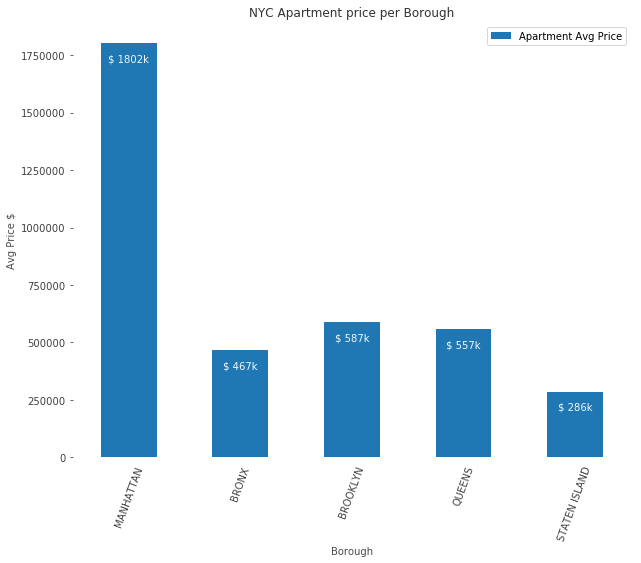

In [185]:
borough_labels = ['MANHATTAN', 'BRONX', 'BROOKLYN', 'QUEENS', 'STATEN ISLAND']

#plt.figure(figsize=(10,8));
ax = borough_trimmean.plot.bar('borough','FULLVAL', label='Apartment Avg Price', figsize=(10,8));

ax.set_title('NYC Apartment price per Borough', alpha=0.8)
ax.set_xticklabels(borough_labels)
ax.set_ylabel('Avg Price $', alpha = 0.7)
ax.set_xlabel('Borough', alpha = 0.7)
plt.xticks(rotation=70)
ax.set_xticklabels(borough_labels)

ax.tick_params(axis='both', top='off', bottom='off', left='on', right='off',
               labelleft='on', labelbottom='on',
               color='#404040',
               labelcolor='#404040')
for i,spine in enumerate(ax.spines.values()):
    spine.set_visible(False)

#
bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
for bar in bars:
    height = bar.get_height();
    price = height/1000
    ax.text(bar.get_x() + bar.get_width()/2, (height-80000), '$ {}k'.format(int(price)),
                 ha='center', color='white', fontsize=10, alpha=0.95);

plt.show();


Evidently Manhattan is the most expensive area to buy an appartment.

In [186]:
school_dist_trimmean = df_prop_value.groupby('school_dist').agg(calc_trim_mean)
school_dist_trimmean.reset_index(inplace=True)

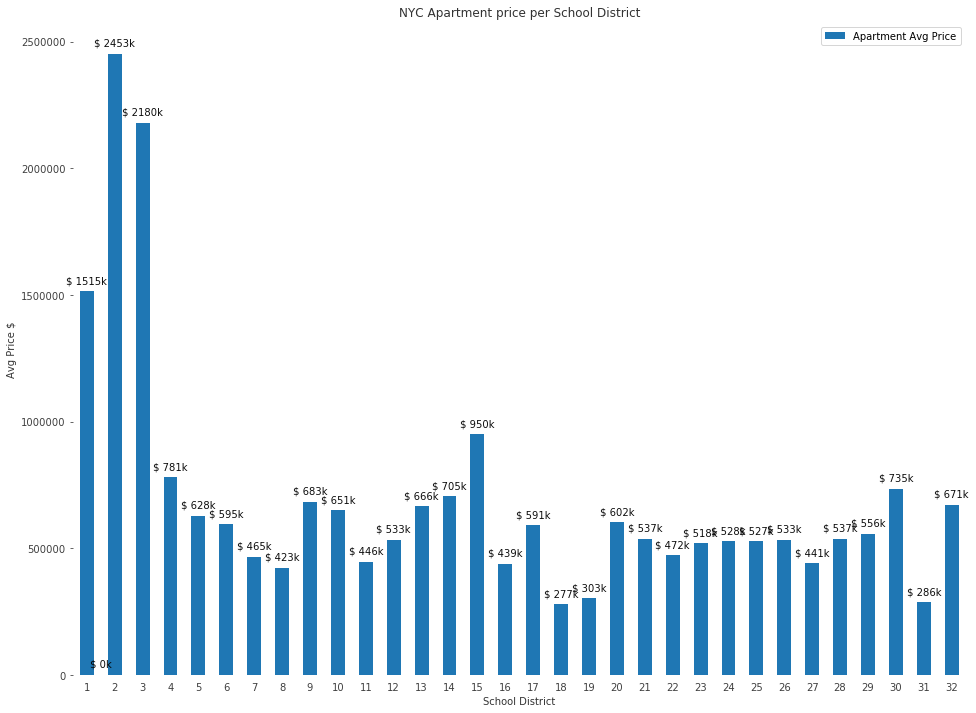

In [187]:
school_dist_labels = [val+1 for val in list(range(32))]

#plt.figure(figsize=(10,8));
ax = school_dist_trimmean.plot.bar('school_dist','FULLVAL', label='Apartment Avg Price', figsize=(16,12));

ax.set_title('NYC Apartment price per School District', alpha=0.8)
ax.set_xticklabels(borough_labels)
ax.set_ylabel('Avg Price $', alpha = 0.8)
ax.set_xlabel('School District', alpha = 0.8)
ax.set_xticks(range(32))
plt.xticks(rotation=0)
ax.set_xticklabels(school_dist_labels)

ax.tick_params(axis='both', top='off', bottom='off', left='on', right='off',
               labelleft='on', labelbottom='on',
               color='#404040',
               labelcolor='#404040')
for i,spine in enumerate(ax.spines.values()):
    spine.set_visible(False)

#
bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
for bar in bars:
    height = bar.get_height();
    price = height/1000
    ax.text(bar.get_x() + bar.get_width()/2, (height+30000), '$ {}k'.format(int(price)),
                 ha='center', color='black', fontsize=10, alpha=0.95);

plt.show();

Ok, it is clearly seen that Manhattan is super expensive while Staten Island property is much most affordable.

To see each School District on a map: [School Districts](http://www.arcgis.com/home/webmap/viewer.html?url=http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/ArcGIS/rest/services/nysd/FeatureServer/0&source=sd)

### Loading Shapefiles


Note that when you download your shapefile you might get multiple shapefile sets. NYC School District shapefile from [Open Data City of New York](https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj/data) I downloaded contained several files. Actual shapefile has .shp extension: *nysd.shp*

So what's in a shapefile? A shapefile is really a set of files that needs to remain together (in the same folder). At minimum, the file should contain .shp, .shx, and .dbf files. The .shp and .shx files define the shapes themselves while the .dbf file will contain metadata on the shape polygons (e.g. state names). The .prj file defines the projection. Those files can be created and edited using awesome, open source [QGIS](http://www.qgis.org/en/site/).

**You absolutely will need to make sure that within the .dbf file the states or districts have the same spelling conventions as in your data set!** You can open .dbf (which is a delimited-data file, just like .csv) with the editor of your choice: Microsoft Excel or via a free [Apache's Open Office](https://www.openoffice.org/). Those programs will let you open and inspect the .dbf file. Don't change it though; it's much easier to change your data file.

Now lets, continue with loading shapefiles.

We'll import it using *fiona*. Also set some variables which define the boundaries of the map area. One way to think about it is that the shapefile you pass to fiona has some bounds which are defined by 2 latitude, longitude pairs: the first defines the lower left (ll) corner of the map and the second defines the upper right (ur) corner of the map.

By subtracting the left edge longitude from the right edge longitude we can determine the width (w) for the map. We can do the same with the latitutde to get the height of the map.

In [188]:
#load the shape file as shp. Here I have saved my shapefile in the folder 'schools/nysd_17c' within my working directory.
#your shapefile should end in .shp
#shp = fiona.open('schools/nysd_17c/nysd.shp')
shp = fiona.open('schools/SchoolDistricts/geo_export_714c55bc-0b01-4c93-84b3-11b4b2716d8f.shp')

#we can access the boundaries (the 2 lat,long pairs) using shp.bounds
bds = shp.bounds

#close the shp file
shp.close()

#define a variable called extra which we will use for padding the map when we display it (in this case I've selected a 10% pad)
extra = 0.1

#define the lower left hand boundary (longitude, latitude)
ll = (bds[0], bds[1])

#define the upper right hand boundary (longitude, latitude)
ur = (bds[2], bds[3])

#concatenate the lower left and upper right into a variable called coordinates
coords = list(chain(ll, ur))

#define variables for the width and the height of the map
w, h = coords[2] - coords[0], coords[3] - coords[1]

### Creating Basemap
Below I create the basemap, defined by the variable m. Note that we need to set the lat and long (lon_0, lat_0) so that it is roughly in the center of what your map. It can be picked just by using Google Maps to figure out where the center is. Here, let's take the average (the midpoint) between the lower and upper longitude and the lower and upper latitude to center.

If you're interested in learning about the Basemap API check out the matplotlib [Basemap documentation here](http://matplotlib.org/basemap/api/basemap_api.html).

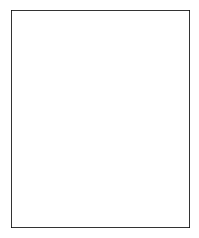

In [261]:
m = Basemap(
    #set projection to 'tmerc' which is apparently less distorting when close-in
    projection='tmerc',

    #set longitude as average of lower, upper longitude bounds
    lon_0 = np.average([bds[0],bds[2]]),

    #set latitude as average of lower,upper latitude bounds
    lat_0 = np.average([bds[1],bds[3]]),

    #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). Not sure what this does...
    ellps = 'WGS84',
    
    #set the map boundaries. Note that we use the extra variable to provide a 10% buffer around the map
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,

    #provide latitude of 'true scale.' Not sure what this means, I would check the Basemap API if you are a GIS guru
    lat_ts=0,

    #resolution of boundary database to use. Can be c (crude), l (low), i (intermediate), h (high), f (full) or None.
    resolution='i',
    
    #don't show the axis ticks automatically
    suppress_ticks=True);

m.readshapefile(
    #provide the path to the shapefile, but leave off the .shp extension
    'schools/SchoolDistricts/geo_export_714c55bc-0b01-4c93-84b3-11b4b2716d8f',

    #name your map something useful (I named this 'srilanka')
    'school_districts',

    #set the default shape boundary coloring (default is black) and the zorder (layer order)
    color='none',
    zorder=2);

We can access the m object by passing m.whatever_shape_name. Each item in m.school_districts is a matrixa 2 x n matrix defining the polygon shape. I believe they are the locations of each point. If you want to take a look at the first polygon in m.srilanka execute:

    In: m.school_districts[0]

In [190]:
print('m.school_districts is a ' + str(type(m.school_districts)) + ' object.')
print('It contains ' + str(len(m.school_districts)) + ' items.')
print('The first list item itself contains ' + str(len(m.school_districts[0])) + ' items.')

m.school_districts is a <class 'list'> object.
It contains 122 items.
The first list item itself contains 488 items.


Notice, that even though we have 32 nominal districts, the basemap object actually shows 122 items! And as an example first item has 488 within - point. Looks like each district has complex structure and presented with several patches.

We can also access the info feature of the polygon to get the metadata. Note that RINGNUM and SHAPENUM were added. I'll be using `school_dis` to merge this with my data as this contains the district number.

In [191]:
m.school_districts_info[0]

{'RINGNUM': 1,
 'SHAPENUM': 1,
 'school_dis': 20.0,
 'shape_area': 242723008.904,
 'shape_leng': 95513.4860103}

### Setting up the DataFrame
Next, we need to take the information from m.srilanka and get it into a nice Panda's dataframe. Shapely's Polygon class would help to convert the x,y information contained in the m.srilanka list to create a defined polygon. More on [Shapely here](http://toblerity.org/shapely/manual.html).

In [192]:
# set up a map dataframe
df_map = pd.DataFrame({

    #access the x,y coords and define a polygon for each item in m.srilanka
    'poly': [Polygon(xy) for xy in m.school_districts],
    #conver NAME_1 to a column called 'district'
    'school_district': [district['school_dis'] for district in m.school_districts_info]})

#add the polygon area
df_map['area_m'] = df_map['poly'].map(lambda x: x.area/1000)

#convert meters to miles
df_map['area_miles'] = df_map['area_m'] * 0.000621371

In [193]:
df_map.head()

,poly,school_district,area_m,area_miles
0,"POLYGON ((24262.28400464167 27838.73793329428,...",20.0,22549.695846,14.011727
1,"POLYGON ((32075.61727346742 32759.41118080938,...",16.0,4344.509584,2.699552
2,"POLYGON ((48082.1420714914 41940.85143518099, ...",26.0,39475.679444,24.529042
3,"POLYGON ((33876.24782532706 33609.37493672247,...",32.0,4821.572429,2.995985
4,"POLYGON ((36306.56079673166 49645.21019755617,...",12.0,6414.468478,3.985765


### Merging datasets into one

The data we want to merge: `school_dist_trimmean` and `df_map` dataframes

School districts would be the matching ids we merge on.

In [194]:
# First rename the column, so that both dataframe column names match.
df_map.rename(columns={'school_district':'school_dist'}, inplace=True)

In [195]:
value_by_school_dist_df = pd.merge(df_map, school_dist_trimmean, on='school_dist')
value_by_school_dist_df.head()

,poly,school_dist,area_m,area_miles,borough,BLOCK,FULLVAL,ZIP
0,"POLYGON ((24262.28400464167 27838.73793329428,...",20.0,22549.695846,14.011727,3,5180.267077,602679.685333,11218.628308
1,"POLYGON ((32075.61727346742 32759.41118080938,...",16.0,4344.509584,2.699552,3,2269.089753,439545.145849,11221.000000
2,"POLYGON ((48082.1420714914 41940.85143518099, ...",26.0,39475.679444,24.529042,4,6985.513953,533311.811628,11361.947442
3,"POLYGON ((33876.24782532706 33609.37493672247,...",32.0,4821.572429,2.995985,3,3259.812201,671501.978469,11237.000000
4,"POLYGON ((36306.56079673166 49645.21019755617,...",12.0,6414.468478,3.985765,2,3643.409639,533621.518072,10460.000000


Looks nice!

### Binning the data
Next, we need to decide how we want to split up the data. For a filled map, we need to decide how many bins we want (call this k) and where to split the bins.

Here are two options:
- use Jenks natural breaks
- define our own breaks

[Jenks natural breaks](http://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) defines optimal breakpoints for the data using a clustering algorithm.

Defining our own breaks (like the example I provided above) is useful for when you want to create a set of maps using the same basemap but plotting different variables. In this case, you generally want to have your data plotted on the same scale for ease of comparison.

Below, toggle the variable Jenks to True if you want to use Jenks bins and False if you want to define your own.

#### Set the bins

In [196]:
# change False to True to use Jenks binning
jenks = True

Next, set the variable you would like to plot. This should be the column name in df_map that you would like to analyze. I have set it to 'Tamils_pct' for the purpose of the walkthrough.

#### Set the variable to plot

In [197]:
# change 'Tamils_pct' to the column name of what you want to plot (e.g. 'Total_pop' for total population)
var_2_analyze = 'FULLVAL'

#### Bin the data

In [198]:
if jenks == True:
    # Calculate Jenks natural breaks for each polygon
    breaks = nb(
        # set the data to use
        value_by_school_dist_df[var_2_analyze].values,

        # since this is an optimization function we need to give it a number of initial solutions to find. 
        # you can adjust this number if you are unsatisfied with the bin results
        initial=1,

        # k is the number of natural breaks you would like to apply. I've set it to 10, but you can change.
        k=10)

else:
    # Define my own breaks [even split each 20 percentage points] Note that the bins are the top range so >20, >40, etc
    # you can change the bins to whatever you like, though they should be based on the data you are analyzing
    # since I am going to plot data on a 0 to 100 scale, I chose these break points
    my_bins = [20,40,60,80,100]
    
    # Calculate the user defined breaks for our defined bins
    breaks = mapclassify.User_Defined(
               
            # set the data to use 
            value_by_school_dist_df[value_by_school_dist_df[var_2_analyze].notnull()][var_2_analyze].values,
            
            #use my bins
            my_bins)

Note that the output of our **breaks** variable from `pysal.esda.mapclassify` has two attributes we can access: `breaks.y` and `breaks.yb`
- *breaks.y* has the actual data that we broke on
- *breaks.yb* has the bin that is output

You can take a look at this if you're interested by executing:

    In: breaks.y
    In: breaks.yb

#### Add Breaks to the DataFrame as bins

In [199]:
# check if 'bins' already exists and drop it if it does so that we can recreate it using our new break information
if 'bins' in value_by_school_dist_df.columns:
    value_by_school_dist_df = value_by_school_dist_df.drop('bins',1)
    print('Bins column already existed, so we dropped the bins column')


# the notnull method lets us match indices when joining
# b is a dataframe of the bins with the var_2_analyze index#
b = pd.DataFrame({'bins': breaks.yb}, index=value_by_school_dist_df[value_by_school_dist_df[var_2_analyze].notnull()].index)

# join b back to df_map
value_by_school_dist_df = value_by_school_dist_df.join(b)

# and handle our NA's if there are any
value_by_school_dist_df.bins.fillna(-1, inplace=True)

#### Create labels for the legend

In [200]:

# check if this is a jenks or user-defined break
if jenks == True:
    
    # if jenks, use these labels
    bin_labels = ["< $%0.0f" % b for b in breaks.bins]
else: 
    
    # if user defined, use these ones
    bin_labels = ["< $%0.0f" % b for b in breaks.bins]
    
print('Here are the bin labels:')
for label in bin_labels:
    print(label)

Here are the bin labels:
< $286234
< $303148
< $441535
< $472451
< $556758
< $705035
< $950044
< $1515608
< $2453464


### Set up the colors

Following useful functions originates from [Stephan Hügel's guide](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.VNZHhVXF8kR) to mapping with Python. He does a very nice job defining reusable functions for mapping numbers to colors.

We now have each polygon bucketed within a bin. We just want to ensure that we evenly split our color scale across the bins. These functions help us do that using some of matplotlib's built in functionality.

In [201]:
# Convenience functions for working with color ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    #cmap = cmap_discretize(cmap, ncolors)
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in np.arange(N)+1]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

### Now Let's plot the actual Map!

All the actual drawing will be done by matplotlib.

It is worth mentioning is that you can customize the colors with any of the matplotlib color maps. Here is a list ofoptions available in the [reference document here](http://matplotlib.org/examples/color/colormaps_reference.html). For creating a filled map you should stick to the **sequential** color maps.

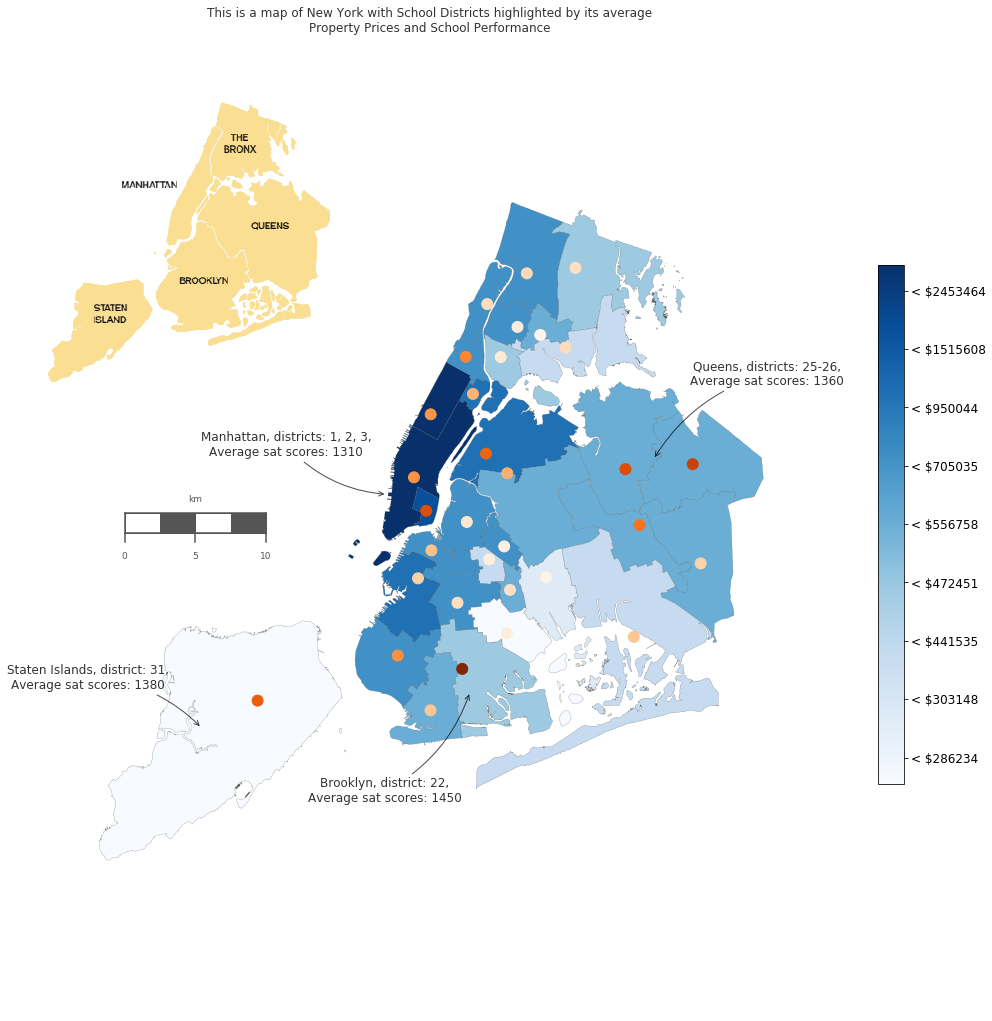

In [259]:
%matplotlib inline

# Following two imports would be useful to creat a thumbnail image of NYC on top of our main graph.
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
import matplotlib.image as mpimg

# initialize the plot
plt.clf();

# define the figure and set the facecolor (e.g. background) to white
fig = plt.figure(facecolor='white');

# ad a subplot called 'ax'
ax = fig.add_subplot(111, frame_on=False);

# use a blue colour ramp ('Blues') - we'll be converting it to a map using cmap()
# you could also use 'Oranges' or 'Greens' 
cmap = plt.get_cmap('Blues')
#cmap = plt.get_cmap('coolwarm')


# draw district with grey outlines
value_by_school_dist_df['patches'] = value_by_school_dist_df['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))


# set the PatchCollection with our defined 'patches'
pc = PatchCollection(value_by_school_dist_df['patches'], match_original=True)

# normalize our bins between the min and max values within the bins
norm = Normalize(vmin=value_by_school_dist_df['bins'].min(), vmax=value_by_school_dist_df['bins'].max())

# impose our color map onto the patch collection
pc.set_facecolor(cmap(norm(value_by_school_dist_df['bins'].values)))
ax.add_collection(pc)

# Add a color bar which has our bin_labels applied
cb = colorbar_index(ncolors=len(bin_labels), cmap=cmap, shrink=0.5, labels=bin_labels)
# set the font size of the labels (set to size 10 here)
cb.ax.tick_params(labelsize=12)

# Create a bit of small print
# smallprint = ax.text(
#     # set the x,y location of the smallprint
#     1, 1,
#     # add whatever text you would like to appear
#     'This is a map of New York with School Districts highlighted by its average\nProperty Prices and School Performance',
#     # set the horizontal/vertical alignment
#     ha='center', va='bottom',
#     # set the size and the color
#     size=14,
#     color='#777777',
#     transform=ax.transAxes)

# Draw a map scale
m.drawmapscale(
    #set the coordinates where the scale should appear
    coords[0] + 0.08, coords[1] + 0.215,
    coords[0], coords[1],
    # what is the max value of the scale (here it's set to 25 for 25 miles)
    10.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5,
    # what units would you like to use. Defaults to km
    #units='mi'
)

# Map School SAT scores per district
m.scatter(longitudes,latitudes,
          s=120,
          zorder=5, 
          latlon=True,
          c=districts['sat_score'], cmap='Oranges')

# set the layout to maximally fit the bounding area
plt.tight_layout()

# define the size of the figure
fig.set_size_inches(16,16)


ax.set_title('This is a map of New York with School Districts highlighted by its average\nProperty Prices and School Performance', alpha=0.8)

# Add text annotations for most interesting findings.
dist_22_longitude = districts[districts['school_dist']=='22']['lon'].values[0]
dist_22_lattitude = districts[districts['school_dist']=='22']['lat'].values[0]


ax.annotate("Staten Islands, district: 31,\nAverage sat scores: 1380",
            xy=(12000, 20000), xycoords='data',
            xytext=(4000, 23500), textcoords='data',
            size=12, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2", alpha=0.7),
            alpha=0.8
            )

ax.annotate("Brooklyn, district: 22,\nAverage sat scores: 1450",
            xy=(31000, 22500), xycoords='data',
            xytext=(25000, 15500), textcoords='data',
            size=12, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2", alpha=0.7),
            alpha=0.8
            )

ax.annotate("Manhattan, districts: 1, 2, 3,\nAverage sat scores: 1310",
            xy=(25100, 36500), xycoords='data',
            xytext=(18000, 40000), textcoords='data',
            size=12, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2", alpha=0.7),
            alpha=0.8
            )

ax.annotate("Queens, districts: 25-26,\nAverage sat scores: 1360",
            xy=(44000, 39000), xycoords='data',
            xytext=(52000, 45000), textcoords='data',
            size=12, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2", alpha=0.7),
            alpha=0.8
            )


# Overlay axis on top of another and display an image of NYC Boroughs!
image = mpimg.imread("schools/NYC_boroughs.png")
ax2 = mpl_il.inset_axes(plt.gca(), width='40%', height='40%', loc=2)
ax2.imshow(image)
ax2.margins(x=0.5)
ax2.axis("off")


# save the figure. Increase the dpi to increase the quality of the output .png. For example, dpi=1000 is super high quality
# note that the figure will be saved as 'sri_lanka_' then the name of the variable under analysis
# you can change this to whatever you want
plt.savefig('schools/school_district_' + var_2_analyze + '.png', dpi=100, alpha=True)

# display the plot
plt.show();

Now, that looks better!

Kind reminder to [reference NYC school districts](https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj/data).

### Findings
---

Manhattan is by far the most expensive Borough in NYC in terms of apartment price, while schools SAT scores may be decent, but not so impressive.

**Now, the main question**: which School Districts are not so expensive to live in NYC and have decent schools according to the SAT score?

1. **Brooklyn** is by far the best according to the map. Apartments are ranging on a lower price spectrum, and SAT score is the highest.
2. **Staten Island** seems to be a 'School haven'! With least estate prices, the Schools in Staten Island hit the upper SAT score level!
3. Some Districts in **Queens** Borough are a fairly good choice. With apartments price OK, and schools with nice performance.

### Wrap up

*Thanks for checking out this article!*

It was more of an exploration of matplotlib, basemap capabilities and those shapefiles. I think the result is quite nice, though there is so much room for improvement.

It is absolutely true, that such graph a better to be built automatically with other libraries or even online tools! Which would be much faster and even provide interactivity for the graphs.

Sources:
- http://brandonrose.org/pythonmap (thanks!)
- http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.Wb-9Z8gjFaR
- http://shallowsky.com/blog/programming/plotting-election-data-basemap.html
- https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj/data